In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

g:\Apps\Anaconda\envs\tf-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 1) Reload the fine-tuned model & tokenizer
model = TFDistilBertForSequenceClassification.from_pretrained('./Models/saved_model_distilbert_balanced')
tokenizer = DistilBertTokenizer.from_pretrained('./Models/saved_model_distilbert_balanced')

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at ./Models/saved_model_distilbert_balanced.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [3]:
# 2) Reload and prepare your balanced dataset
df = pd.read_csv("../Data/NLP/news_sentiment_balanced.csv")
df["text"] = (
    df["title_clean"].fillna("") + " "
  + df["description_clean"].fillna("") + " "
  + df["content_clean"].fillna("")
)
le = LabelEncoder()
df["label"] = le.fit_transform(df["sentiment"])

In [4]:
# 3) Same stratified split to get the validation set
_, val_texts, _, val_labels = train_test_split(
    df["text"].tolist(),
    df["label"].tolist(),
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

In [5]:
# 4) Tokenize and batch
val_enc = tokenizer(val_texts, truncation=True, padding=True, max_length=64, return_tensors="tf")
val_ds  = tf.data.Dataset.from_tensor_slices(dict(val_enc)).batch(8)

In [6]:
# 5) Predict
logits     = model.predict(val_ds).logits
pred_labels = tf.argmax(logits, axis=1).numpy()
true_labels = np.array(val_labels)

5/5 [==============================] - 4s 39ms/step


<Figure size 600x500 with 0 Axes>

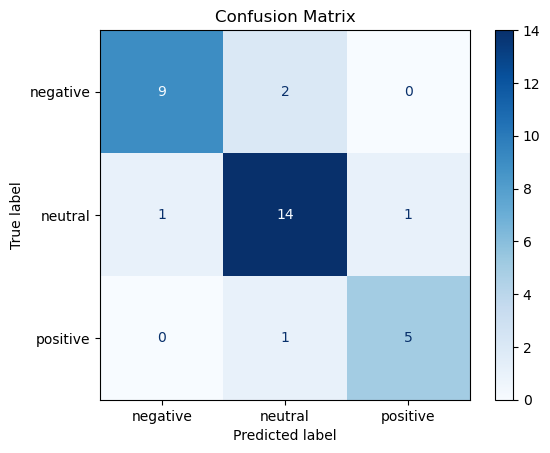

In [7]:
# 6) Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
plt.figure(figsize=(6,5))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

In [8]:
# 7) Classification report
print("\nClassification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=le.classes_))


Classification Report:

              precision    recall  f1-score   support

    negative       0.90      0.82      0.86        11
     neutral       0.82      0.88      0.85        16
    positive       0.83      0.83      0.83         6

    accuracy                           0.85        33
   macro avg       0.85      0.84      0.85        33
weighted avg       0.85      0.85      0.85        33

